# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data.csv")

## Data Validation

In [3]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [4]:
df.shape

(947, 8)

In [5]:
#Percentage of missing values in the data

df.isna().sum() / df.shape[0] * 100

recipe           0.000000
calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
dtype: float64

In [6]:
#Check which rows have more than 2 values missing.

missing_count = df.isnull().sum(axis=1)
filtered_data = df[missing_count > 3]
filtered_data.shape

(52, 8)

In [7]:
#Cross referencing with all the data
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

There are 52 rows with 2 or more columns with missing values, let's drop it

In [8]:
#Let's create a new dataframe, because we may want to use the original one later

df2 = df[missing_count < 3]

In [9]:
df2.isna().sum()

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    360
dtype: int64

In [10]:
#Check unique values for each column

columns = list(df2.select_dtypes("object").columns)

print("Unique Values for each categorical column:")
for c in columns:
    print(f"{c}: {list(df2[c].unique())}")

Unique Values for each categorical column:
category: ['Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Pork', 'Chicken', 'Vegetable', 'Meat', 'Dessert']
servings: ['4', '1', '2', '6', '4 as a snack', '6 as a snack']
high_traffic: ['High', nan]


In every categorical column, nothing seems to be wrong.

In [11]:
df2.describe()

,recipe,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296
std,272.763283,453.020997,43.949032,14.679176,36.369739
min,2.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,475.000000,288.550000,21.480000,4.550000,10.800000
75%,708.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


From the descriptive statistics, nothing seems outside the ordinary in the numeric columns

In [12]:
#To make our analysis, the column recipe is not needed, let's drop it

df2 = df2.drop("recipe", axis=1)

Since the column high_traffic as only one unique value "high", we can assume every missing value is a recipe with low traffic, let's replace all NANs with "Low"

In [13]:
df2["high_traffic"] = df2["high_traffic"].fillna("Low")

In [14]:
df2["high_traffic"].value_counts()

High    535
Low     360
Name: high_traffic, dtype: int64

In [15]:
#Convert object columns to category

df2[columns] = df2[columns].astype("category")
df2.dtypes

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings        category
high_traffic    category
dtype: object

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      895 non-null    category
 5   servings      895 non-null    category
 6   high_traffic  895 non-null    category
dtypes: category(3), float64(4)
memory usage: 38.3 KB


In [17]:
#Check for duplicates

df2.duplicated().sum()

0

The data is clean and read to be analyzed.

## Exploratory Data Analysis

In [18]:
#functions

def plot_percentages_count_2(df, column, hue, padd, colors=None, count_color=None):
    
    #create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns=hue, values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 7), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count", width=0.6)

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.78, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{int(c)}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=60, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Recipes")
    sns.despine()
    
    plt.savefig(f'{column}.png', bbox_inches="tight")
    
    plt.show()

In [19]:
def numeric_cols_analysis(df, column, fig_size):
    
    """
        Takes in a dataframe and one column and returns 4 plots with distributions and descriptive statistics of that column a the           traffic column.
        
        Inputs:
            df: DataFrame
            column: column to analyse against traffic
            fig_size: tuple of values to change the dimensions of the multiple plots
        Returns:
            Four plots, with distributions and descriptive statistics
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(fig_size))
    sns.set_palette(colors)

    #First Plot - Normal Data KDE
    ax1 = sns.kdeplot(data=df, x=column, hue="high_traffic", ax=axs[0, 0], legend=False).set(title=f'Distribution of the {column.capitalize()} per Traffic')
    
    #Log Data    
    log_df = df[[column, "high_traffic"]]
    log_df["log"] = np.log(df[column])

    #Second Plot - Log Scale Data KDE
    ax2 = sns.kdeplot(log_df, x="log", hue="high_traffic", ax=axs[0, 1], legend=False).set(title=f'Log Distribution of the {column} per Traffic')

    #Third Plot - Boxplot normal data
    ax3 = sns.boxplot(x=column, y="high_traffic", data=df, ax=axs[1, 0]).set(title=f'Boxplot of the {column} per Traffic')
    axs[1, 0].set_ylabel('Traffic')

    #Fourth Plot - Boxplot normal data with categories
    ax4 = sns.boxplot(data=df, x=column, y="category", hue="high_traffic", ax=axs[1, 1]).set(title=f'Boxplot of the {column} per Traffic regarding the Categories')
    
    plt.legend().remove()

    #Figure settings
    fig.suptitle(f'{column.capitalize()}', fontsize=24)
    fig.legend(bbox_to_anchor=(0.56, 0.51), ncol=2)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    plt.show()

In [20]:
#Plof config

#colors: red: #ec5966, grey: #b3aba3, greyish:#ddd0c6

colors = ["#DF9429", "#a8aaad", "#4d4845"]

sns.set_palette(colors)

# Traffic Column

In [21]:
#Percentage of high and low traffic recipes
df2.high_traffic.value_counts() / df2.high_traffic.count() * 100

High    59.776536
Low     40.223464
Name: high_traffic, dtype: float64

# Categorical Columns

## Category vs High Traffic

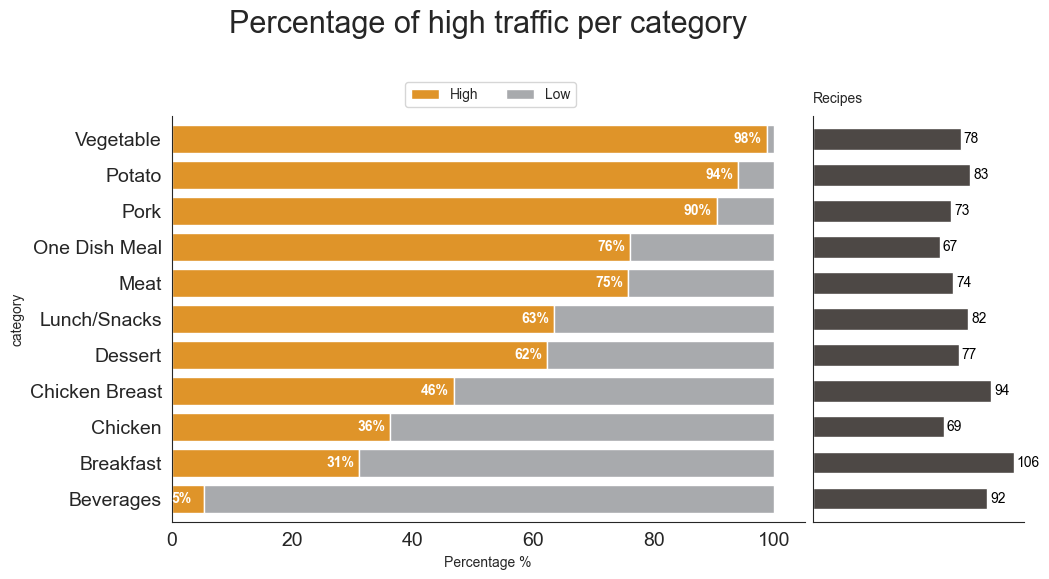

In [22]:
plot_percentages_count_2(df2, "category", "high_traffic", -23.5, colors, count_color=colors[2])

As showed in the chart, there are some categories with a high traffic (Vegetable, Potato and Pork) and others with low traffic like Chicken, Breakfast and, with the lowest traffic, Beverages, so is fair to assume that the Category column has a big weight on a recipe having high or low traffic

## Servings vs High Traffic

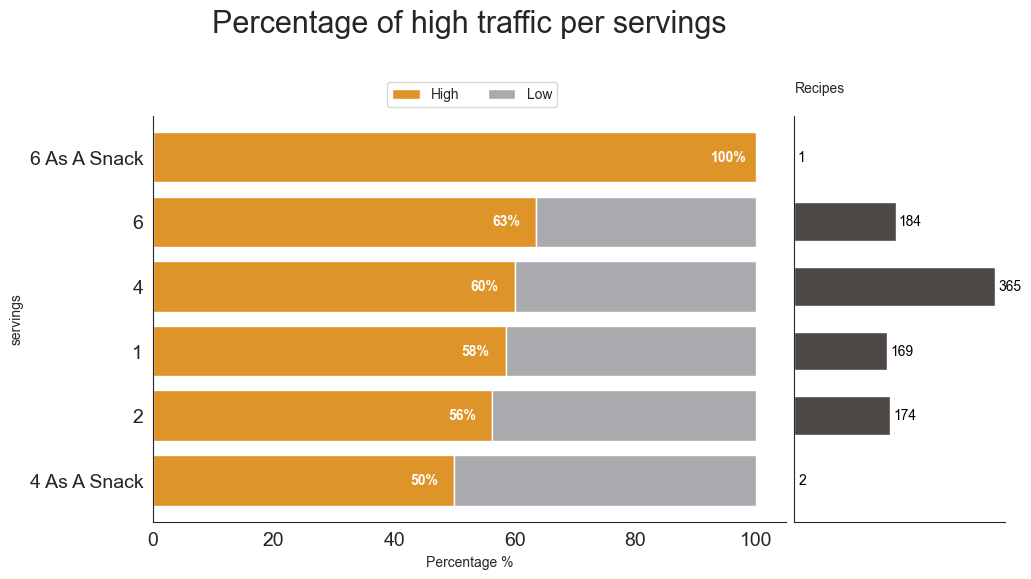

In [23]:
plot_percentages_count_2(df2, "servings", "high_traffic", -32, colors, count_color=colors[2])

Putting aside the "6 As A Snack" and "4 As A Snack" servings, because entries quantity is so low, they became insignificant, we can observe that recipes with 6 servings have more traffic and with 2 have the lowest, eventhought there's not a significant difference

# Numeric Columns

## Calories vs High Traffic

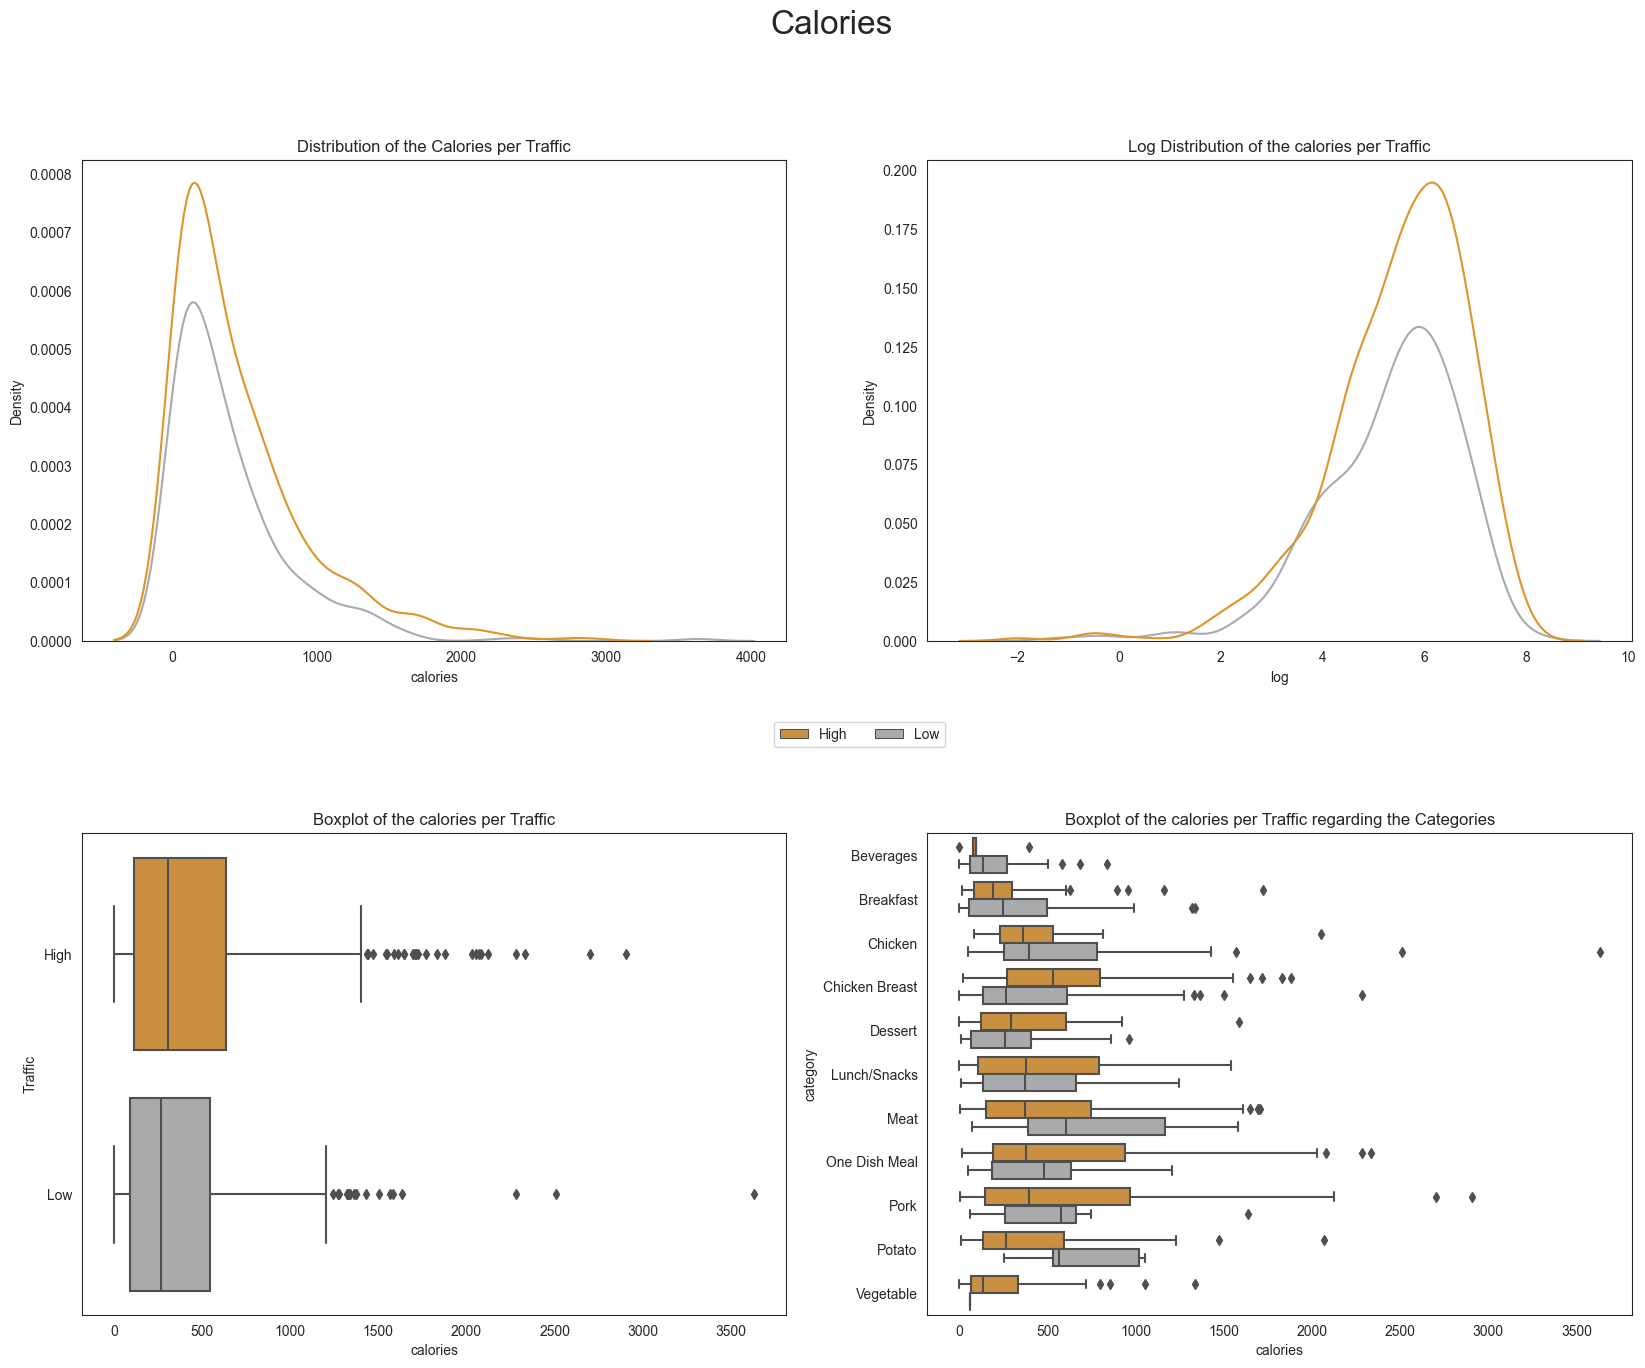

In [24]:
numeric_cols_analysis(df2, "calories", (20, 15))

There's no significant different on the descriptive statistics of calories columns regarding the traffic

## Carbohydrates vs High Traffic

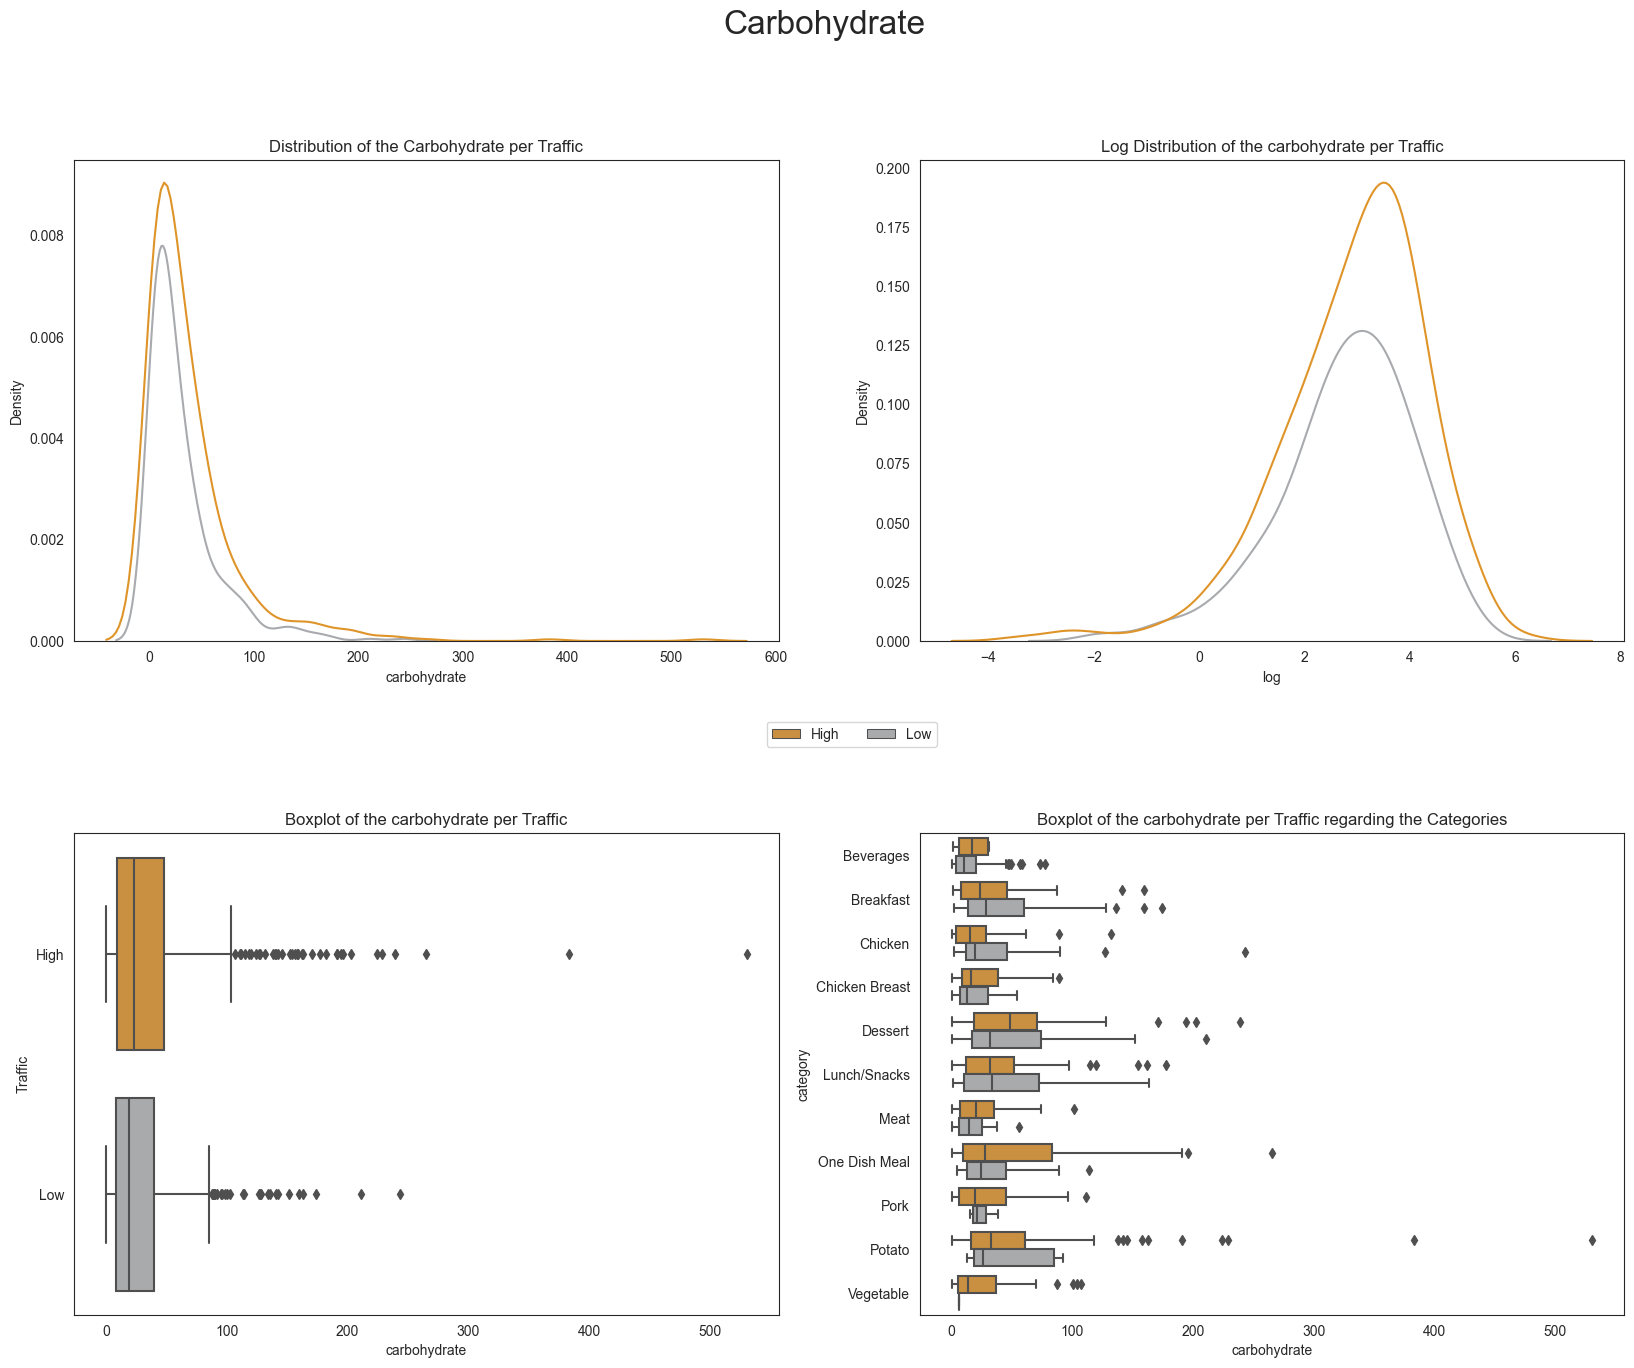

In [25]:
numeric_cols_analysis(df2, "carbohydrate", (20, 15))

We can see the carbohydrate column is similar to the previous (calories)

## Sugar vs Traffic

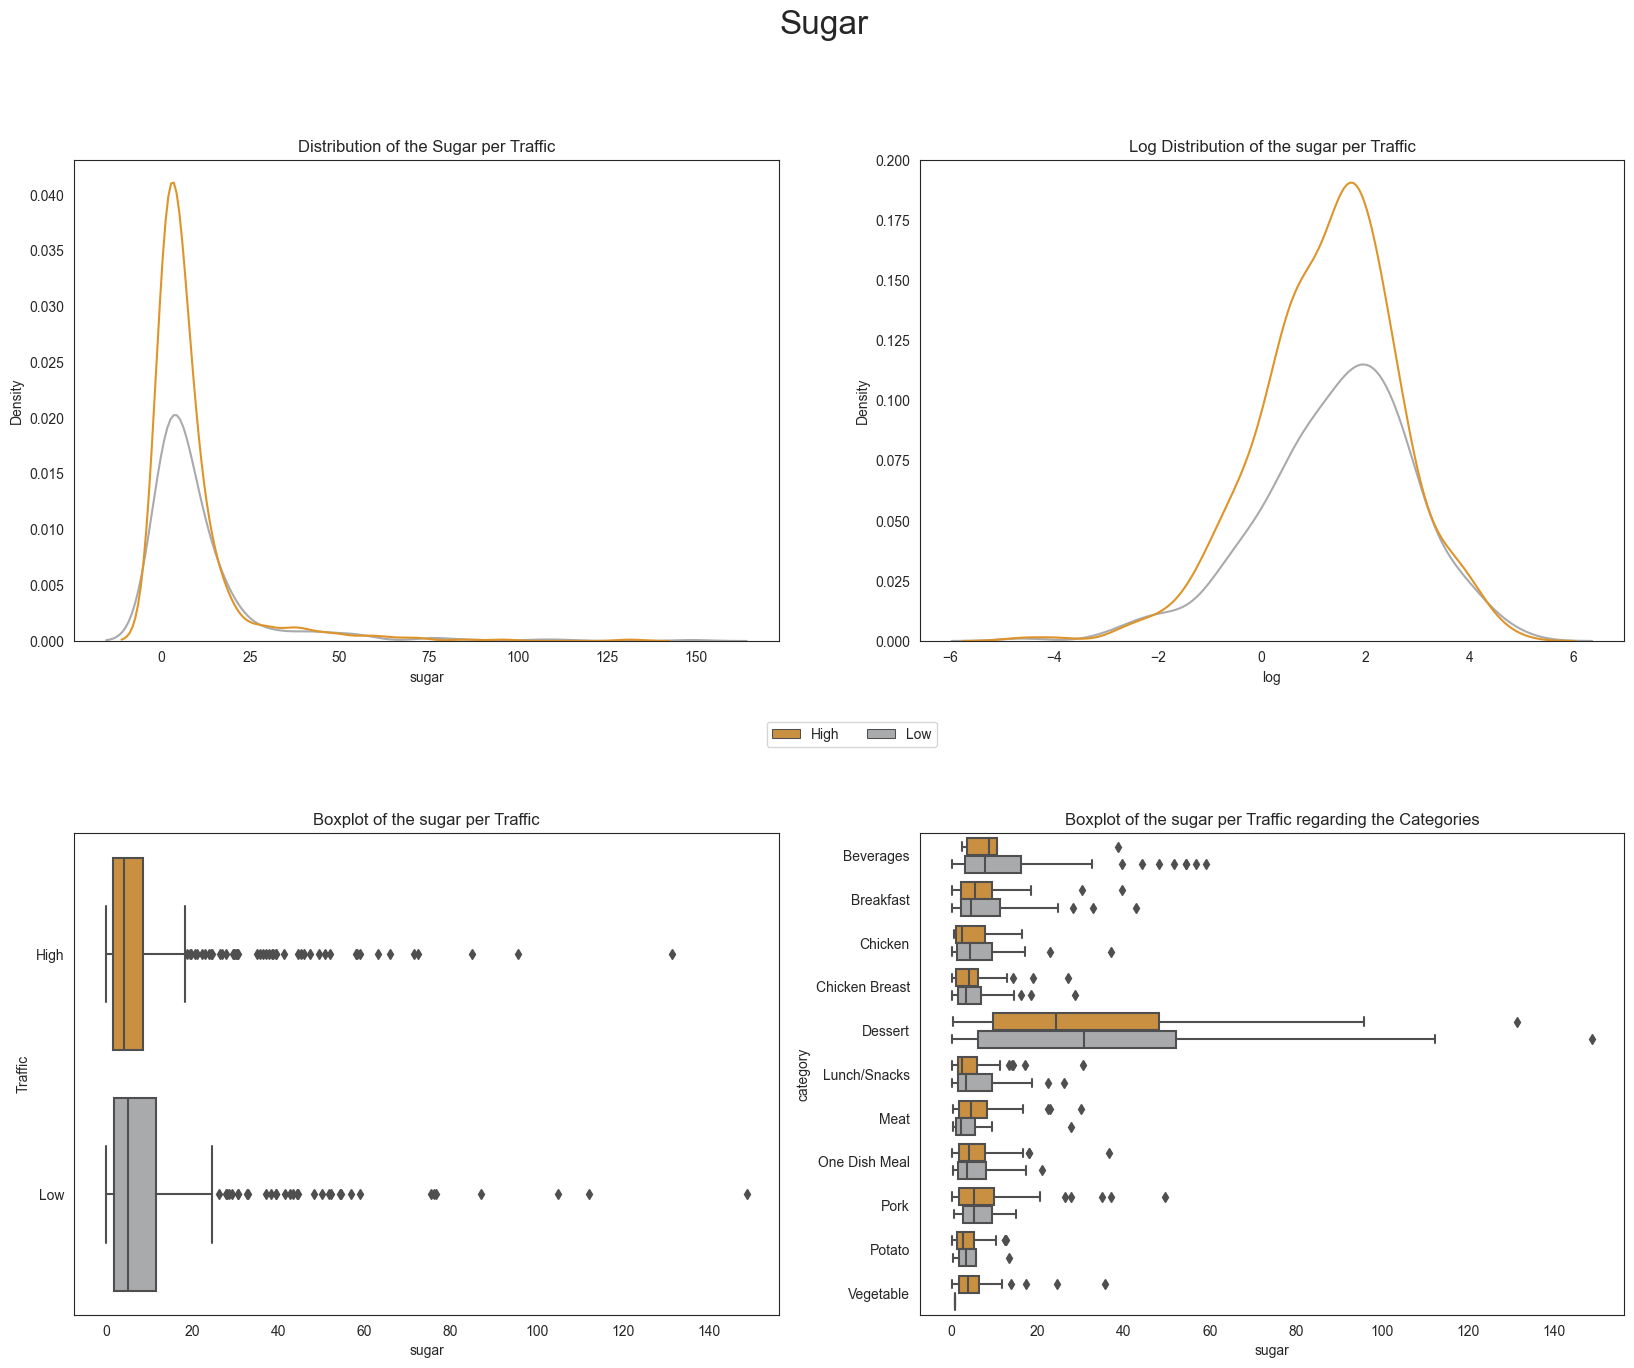

In [26]:
numeric_cols_analysis(df2, "sugar", (20, 15))

## Protein vs Traffic

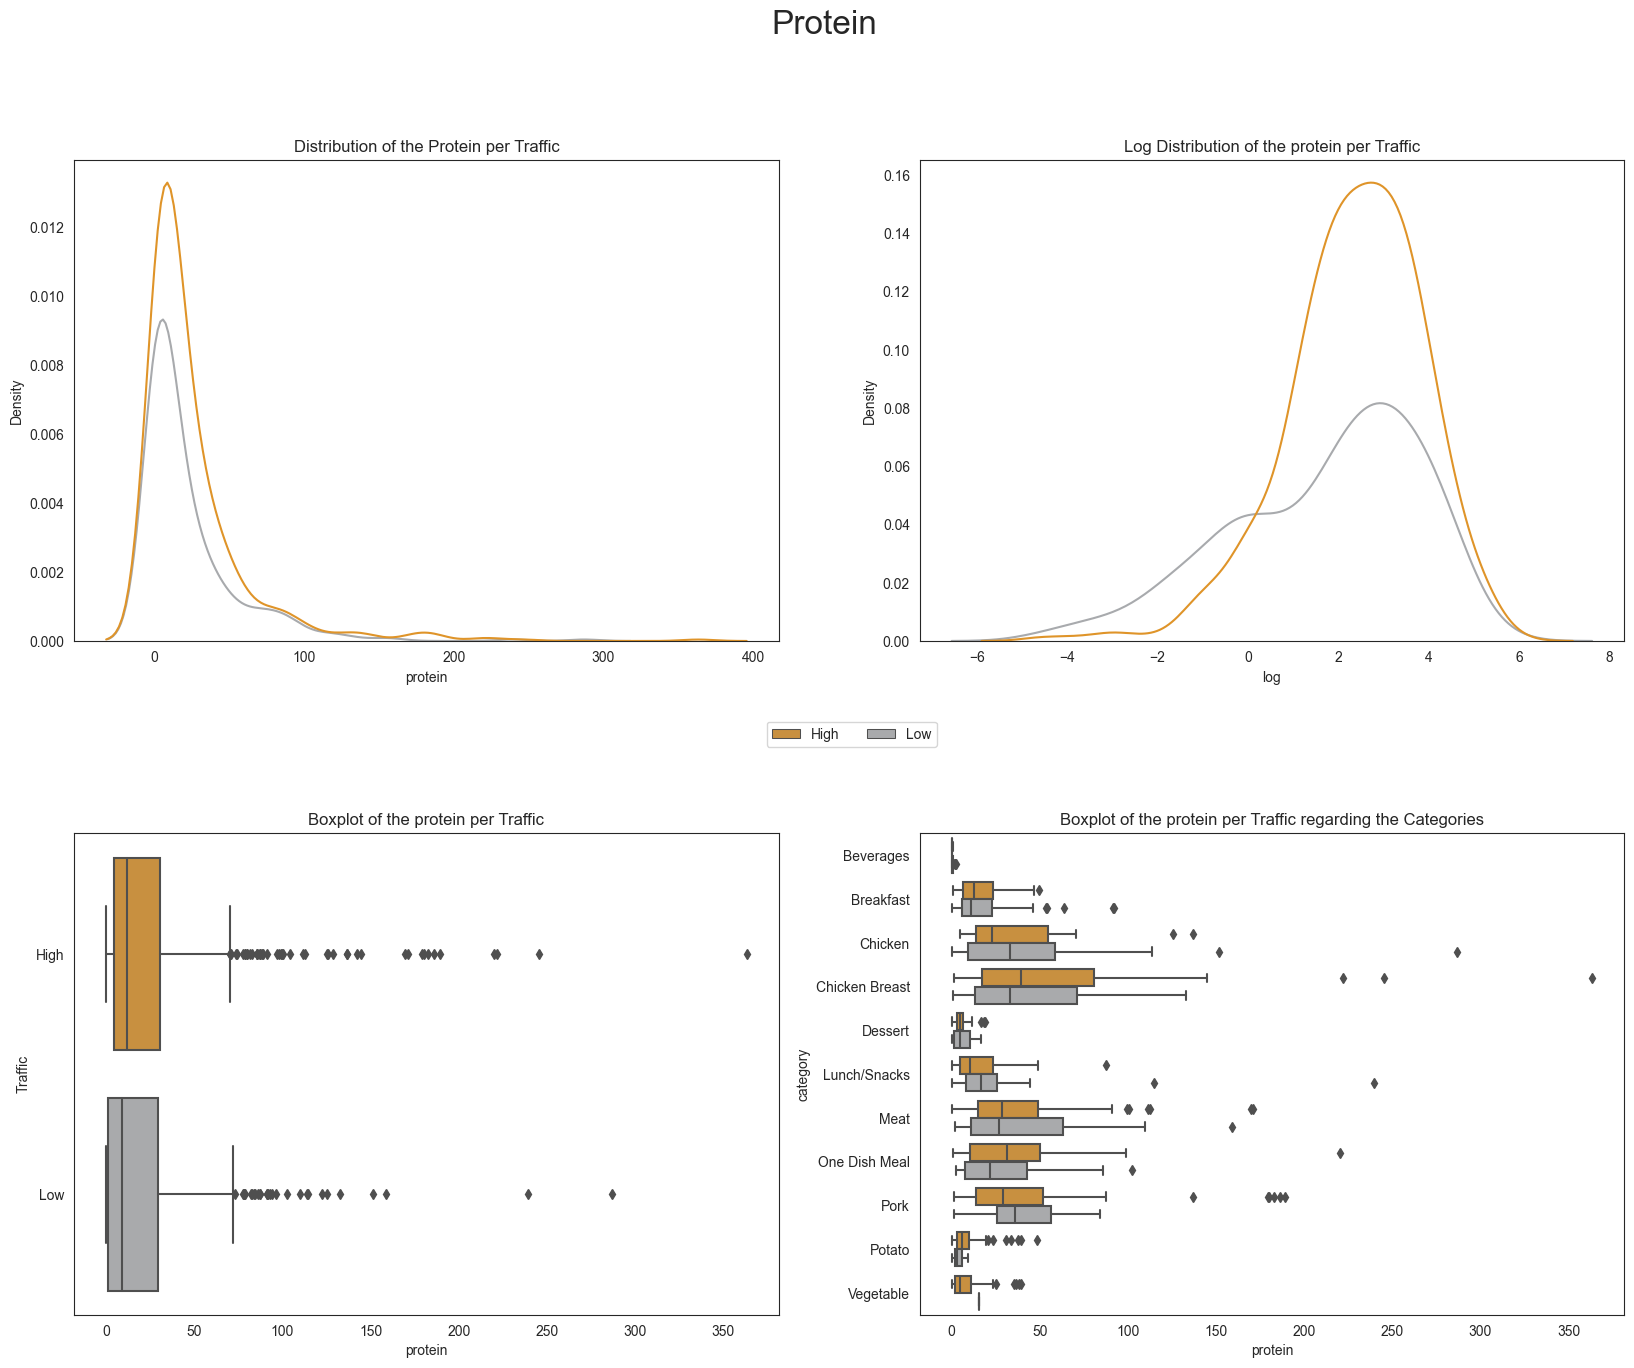

In [27]:
numeric_cols_analysis(df2, "protein", (20, 15))

In [28]:
data_melt = pd.melt(df2, id_vars=['high_traffic'], value_vars=['calories', 'sugar', 'protein', 'carbohydrate'], var_name='Columns')

In [29]:
data_melt["value"] = np.log(data_melt["value"])

In [30]:
data_melt

,high_traffic,Columns,value
0,High,calories,3.568969
1,Low,calories,6.818137
2,High,calories,4.575020
3,Low,calories,3.297687
4,High,calories,6.538357
...,...,...,...
3575,High,carbohydrate,4.430102
3576,Low,carbohydrate,1.669592
3577,High,carbohydrate,3.381675
3578,High,carbohydrate,3.577110


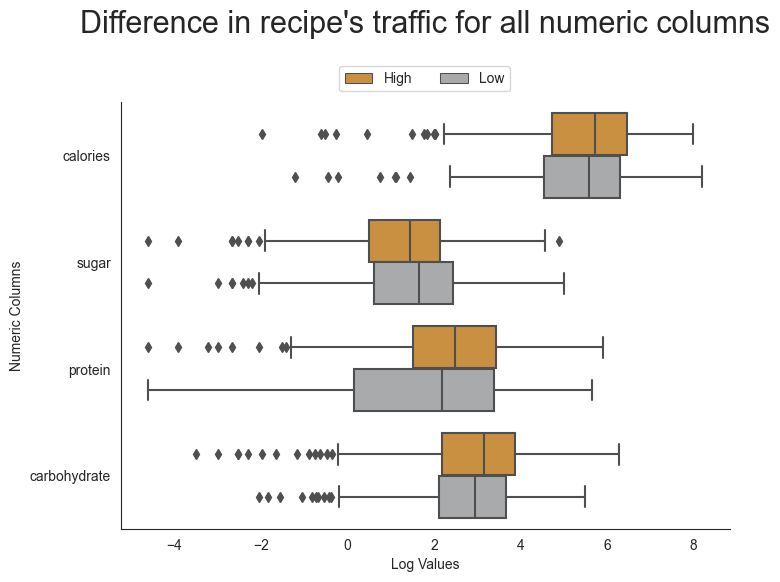

In [31]:
ax = sns.catplot(x='value', y='Columns', hue='high_traffic', kind='box', data=data_melt, legend=False, aspect=1.5, palette=colors)
plt.title("Difference in recipe's traffic for all numeric columns", pad=50, fontdict={"fontsize":22})

plt.xlabel("Log Values")
plt.ylabel("Numeric Columns")
plt.legend(bbox_to_anchor=(0.65, 1.1), ncol=3)

sns.despine()

plt.savefig('boxplot.png', bbox_inches="tight")
plt.show()

#### Overall, the Calories, Sugar, Carbohydrate and Protein, are pretty similar when analyzing the connection with the traffic column. Taking a look at the distributions the high traffic recipes have a higher density, but that can be explained by the fact that, those represent 60% of the data

Is possible that, in model development those columns would not contribute to must for the final score, so those will be removed from the data and the dropped rows will be added to the data frame, so we can have a bigger dataset to train and test

# Correlation

In [32]:
#drop the 3 rows with "4 as a snack" and "6 as a snack" because they don't have any weight in the data for the work needed to convert them to our model
to_remove = ["4 as a snack", "6 as a snack"]

#remove the rows
df2 = df2[~df2.servings.isin(to_remove)]

#remove categories and convert the column to numeric
df2["servings"] = df2["servings"].cat.remove_categories(to_remove)

#convert "servings" to numeric
df2["servings"] = df2["servings"].astype("int")

Category Column unique values: 11


<AxesSubplot: >

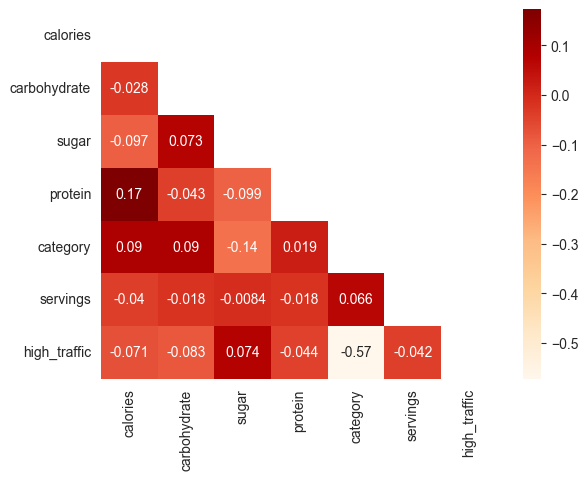

In [33]:
#print unique values from the categoty column
print(f"Category Column unique values: {len(df2['category'].unique())}")

#copy numeric columns from main df
pre_corr_df = df2.copy()

#Binary Encode high_traffic column
pre_corr_df["high_traffic"] = pre_corr_df["high_traffic"].map({"High":0, "Low":1})

#create new dataframe to use later and Label Encode "category" column
corr_df = pre_corr_df.copy()
corr_df["category"] = pre_corr_df["category"].cat.codes

#convert categories to float
corr_df[["servings", "category", "high_traffic"]] = corr_df[["servings", "category", "high_traffic"]].astype("float")

#Plot corr
corr_df = corr_df.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, annot=True, mask=mask, cmap="OrRd")

It appears that the recipes category has the strongest correlation with the traffic it receives.

# Model Development

Datasets
- To maximize the amount of data, let's create a dataframe in which missing values are imputed with the median for each category and serving size, and use it to see if it results in better scores.
 - If, according to the correlation matrix, the columns for calories, sugar, protein, and carbohydrates do not improve our model, let's remove them and add back the rows that were dropped due to missing values.

### Imputed DataFrame

In [34]:
#Dataframe with imputed values
columns = ["calories", "carbohydrate", "sugar", "protein"]

df3 = df.copy()

df3 = df3.drop("recipe", axis=1)

df3["high_traffic"] = df3["high_traffic"].fillna("Low")

In [35]:
#Table with the medians

table = df3.groupby(["category", "servings"])[columns].median().reset_index()
table.head()

,category,servings,calories,carbohydrate,sugar,protein
0,Beverages,1,154.465,11.120,9.385,0.400
1,Beverages,2,199.340,13.870,7.580,0.560
2,Beverages,4,129.450,12.415,9.885,0.405
3,Beverages,6,88.170,8.840,6.470,0.400
4,Breakfast,1,253.465,28.850,3.590,13.975


In [36]:
#merge the two tables so the correct values are linked to the correcto rows
df3 = df3.merge(table, on=["category", "servings"])

In [37]:
#fill in the missing values

for c in columns:
    df3[f"{c}_x"] = df3[f"{c}_x"].fillna(df3[f"{c}_y"])

In [38]:
df3 = df3.drop(["calories_y", "carbohydrate_y", "sugar_y", "protein_y"], axis=1)

In [39]:
#drop the 3 rows with "4 as a snack" and "6 as a snack" because they don't have any weight in the data for the work needed to convert them to our model
to_remove = ["4 as a snack", "6 as a snack"]

#remove the rows
df3 = df3[~df3.servings.isin(to_remove)]

In [40]:
df3.head()

,calories_x,carbohydrate_x,sugar_x,protein_x,category,servings,high_traffic
0,538.52,11.83,2.53,35.12,Pork,6,High
1,538.52,3.78,3.37,3.79,Pork,6,High
2,131.51,33.32,1.70,87.11,Pork,6,High
3,538.52,11.83,2.53,35.12,Pork,6,High
4,2906.01,3.52,1.89,179.22,Pork,6,High


In [41]:
df3.isna().sum()

calories_x        0
carbohydrate_x    0
sugar_x           0
protein_x         0
category          0
servings          0
high_traffic      0
dtype: int64

In [42]:
#Encoding values

df_imputed = df3.copy()

In [43]:
#OneHotEncoding the category and servings columns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

ohe = OneHotEncoder()
df_imputed = pd.get_dummies(df_imputed, columns=["category"], prefix='cat')
df_imputed = pd.get_dummies(df_imputed, columns=["servings"], prefix='serv')

In [44]:
#Label Encoding the Target (high_traffic) column

le = LabelEncoder()
df_imputed.high_traffic = le.fit_transform(df_imputed.high_traffic)

In [45]:
df_imputed.head()

,calories_x,carbohydrate_x,sugar_x,protein_x,high_traffic,cat_Beverages,cat_Breakfast,cat_Chicken,cat_Chicken Breast,cat_Dessert,cat_Lunch/Snacks,cat_Meat,cat_One Dish Meal,cat_Pork,cat_Potato,cat_Vegetable,serv_1,serv_2,serv_4,serv_6
0,538.52,11.83,2.53,35.12,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,538.52,3.78,3.37,3.79,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,131.51,33.32,1.70,87.11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,538.52,11.83,2.53,35.12,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,2906.01,3.52,1.89,179.22,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [46]:
df_imputed.shape

(944, 20)

### Dataframe with the missing values rows dropped

In [47]:
df_drop = df2.copy()

In [48]:
ohe = OneHotEncoder()
df_drop = pd.get_dummies(df_drop, columns=["category"], prefix='cat')
df_drop = pd.get_dummies(df_drop, columns=["servings"], prefix='serv')

In [49]:
#Label Encoding the Target (high_traffic) column

le = LabelEncoder()
df_drop.high_traffic = le.fit_transform(df_drop.high_traffic)

In [50]:
df_drop.head()

,calories,carbohydrate,sugar,protein,high_traffic,cat_Beverages,cat_Breakfast,cat_Chicken,cat_Chicken Breast,cat_Dessert,cat_Lunch/Snacks,cat_Meat,cat_One Dish Meal,cat_Pork,cat_Potato,cat_Vegetable,serv_1,serv_2,serv_4,serv_6
1,35.48,38.56,0.66,0.92,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,914.28,42.68,3.09,2.88,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,97.03,30.56,38.63,0.02,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,27.05,1.85,0.80,0.53,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,691.15,3.46,1.65,53.93,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [51]:
df_drop.shape

(892, 20)

# Model evaluation

As this is a binary classification problem with only two possible outcomes (High or Low), we will try four different classification models (Ridge Classifier, Gaussian Naive Bayes, Bernoulli Naive Bayes, and Logistic Regression) and compare their performance to determine which one works best for our data.

In [52]:
#Dependencies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

In [53]:
#function

def eval_models(data):
    
    """
        Evaluates, on four models (Logistic Regression, Ridge Classifier, Gaussian Naives Bayes and Bernoulli Naive Bayes), the accuracy, precision, f1 and Recal metrics.
        Input: Dataframe to test
        Output: Returns a Dataframe with the evaluations for each model on the provided data
    """
    
    X = data.drop("high_traffic", axis=1)
    y = data["high_traffic"]
    
    evaluations = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])
    
    #Logistic Regression
    lr = LogisticRegression()
    scores = cross_validate(lr, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])
    
    evaluations["Logistic Regression"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                         round(scores['test_precision'].mean(), 4) * 100,
                                         round(scores['test_recall'].mean(), 4) * 100,
                                         round(scores['test_f1'].mean(), 4) * 100]

    #Ridge Classifier
    rc = RidgeClassifier()
    scores = cross_validate(rc, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])
    
    evaluations["Ridge Classifier"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                         round(scores['test_precision'].mean(), 4) * 100,
                                         round(scores['test_recall'].mean(), 4) * 100,
                                         round(scores['test_f1'].mean(), 4) * 100]
    
    #Gaussian Naive Bayes
    gnb = GaussianNB()
    scores = cross_validate(gnb, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])

    evaluations["Gaussian Naive Bayes"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                     round(scores['test_precision'].mean(), 4) * 100,
                                     round(scores['test_recall'].mean(), 4) * 100,
                                     round(scores['test_f1'].mean(), 4) * 100]
    
    #Bernoulli Naive Bayes
    bnb = BernoulliNB()
    scores = cross_validate(bnb, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])

    evaluations["Bernoulli Naive Bayes"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                     round(scores['test_precision'].mean(), 4) * 100,
                                     round(scores['test_recall'].mean(), 4) * 100,
                                     round(scores['test_f1'].mean(), 4) * 100]
    
    return evaluations.style.highlight_max(color='yellow', axis = 1)

### Data Frame with dropped rows and all columns

In [54]:
eval_models(df_drop)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,76.130000,75.680000,71.750000,75.900000
Precision,72.430000,71.480000,61.110000,71.050000
Recall,66.870000,67.150000,83.020000,68.820000
F1,69.190000,68.920000,70.300000,69.590000


### Data Frame with values imputed

In [55]:
eval_models(df_imputed)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,70.130000,68.440000,66.100000,70.020000
Precision,62.830000,61.320000,55.630000,63.180000
Recall,68.610000,69.420000,77.210000,72.940000
F1,64.060000,63.240000,64.010000,65.340000


It is clear that imputation does not improve the performance of our model. Therefore, let's try standardizing the data to see if it can help.

In [56]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

In [57]:
#Dataframe with droped rows

df_drop_std = df_drop.copy()

df_drop_std[["calories", "carbohydrate", "sugar", "protein"]] = ss.fit_transform(df_drop_std[["calories", "carbohydrate", "sugar", "protein"]])

eval_models(df_drop_std)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,75.790000,75.680000,71.190000,74.450000
Precision,72.120000,71.480000,60.470000,71.090000
Recall,66.040000,67.150000,84.410000,63.810000
F1,68.580000,68.920000,70.290000,66.590000


In [58]:
#Dataframe with imputad rows

df_imputed_std = df_imputed.copy()

df_imputed_std[["calories_x", "carbohydrate_x", "sugar_x", "protein_x"]] = ss.fit_transform(df_imputed_std[["calories_x", "carbohydrate_x", "sugar_x", "protein_x"]])

eval_models(df_imputed_std)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,67.490000,68.440000,67.270000,69.920000
Precision,60.780000,61.320000,56.540000,63.670000
Recall,64.360000,69.420000,81.260000,69.170000
F1,60.260000,63.240000,65.830000,63.920000


After trying standardization, we found that it did not improve our model, even with leakage. Therefore, let's try dropping the columns calories, carbohydrates, sugar, and protein and focus solely on the resulting dataframe.

In [59]:
#Remove the 4 columns

df_drop = df_drop.drop(["calories", "carbohydrate", "sugar", "protein"], axis=1)

In [60]:
eval_models(df_drop)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,75.900000,76.020000,71.420000,75.900000
Precision,72.240000,71.950000,60.470000,71.050000
Recall,66.600000,67.430000,86.350000,68.820000
F1,68.880000,69.300000,70.880000,69.590000


Since having the 4 columns doesn't help much, let's remove them for now, as it will be less computationally intensive.
 - As observed in the data validation step, the rows that were dropped had missing values only in the 'calories', 'carbohydrate', 'sugar', and 'protein' columns. Therefore, we should create a new dataframe with all rows since we are going to drop the columns with missing values.

In [61]:
df_all = df.copy()

#Drop the columns
df_all = df_all.drop(["recipe", "calories", "carbohydrate", "sugar", "protein"], axis=1)

In [62]:
df_all.isna().sum()

category          0
servings          0
high_traffic    373
dtype: int64

In [63]:
df_all["high_traffic"] = df_all["high_traffic"].fillna("Low")

In [64]:
df_all.isna().sum()

category        0
servings        0
high_traffic    0
dtype: int64

In [65]:
#OneHotEncoding the category and servings columns
ohe = OneHotEncoder()
df_all = pd.get_dummies(df_all, columns=["category"], prefix='cat')
df_all = pd.get_dummies(df_all, columns=["servings"], prefix='serv')

#Label Encoding the Target (high_traffic) column
le = LabelEncoder()
df_all.high_traffic = le.fit_transform(df_all.high_traffic)

In [66]:
df_all.shape

(947, 18)

In [67]:
#Let's evaluated the new dataframe

eval_models(df_all)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,76.560000,76.140000,64.950000,76.030000
Precision,73.360000,71.930000,57.220000,70.980000
Recall,65.190000,65.990000,84.620000,67.330000
F1,68.570000,68.440000,64.440000,68.720000


### Our best performing model is Logistic Regression, so let's perform hyperparameter tuning on it.

# Hyperparameter Tunning

In [68]:
#Basic Hyperparameter Tunning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score

In [69]:
X = df_all.drop("high_traffic", axis=1)
y = df_all["high_traffic"]

In [70]:
model = LogisticRegression()

In [71]:
#Because of compatibality issues between the solvers and the panaties, let's check first wich solver to use

solvers = ["lbfgs", "newton-cg"]
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]

# Define the scoring functions
scorer_precision = make_scorer(precision_score)
scorer_accuracy = make_scorer(accuracy_score)
scorer_f1 = make_scorer(f1_score)

scoring={'accuracy': scorer_accuracy,
         'precision': scorer_precision,
         'f1': scorer_f1}

In [72]:
grid = dict(solver=solvers, 
            C=c_values)

cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=45)

grid_search = GridSearchCV(estimator=model,
                                 param_grid=grid, 
                                 n_jobs=-1, 
                                 cv=cv, 
                                 scoring=scoring, 
                                 refit="accuracy")

grid_result = grid_search.fit(X, y)

In [73]:
# Get the best parameters and best scores
best_params = grid_search.best_params_
best_scores = grid_search.best_score_

print("Best parameters:", best_params)
print("Best scores:", best_scores)

Best parameters: {'C': 1.0, 'solver': 'lbfgs'}
Best scores: 0.7669915529564653


In [74]:
hyper_results = dict()
for i, c in enumerate(grid_search.cv_results_["params"]):
    hyper_results[f"test {i}"] = {"solver":c["solver"], 
                                  "C":c["C"], 
                                  "Accuracy":grid_search.cv_results_[f"split{i}_test_accuracy"][grid_search.cv_results_[f"split{i}_test_accuracy"] > 0].mean(), 
                                  "Precision":grid_search.cv_results_[f"split{i}_test_precision"][grid_search.cv_results_[f"split{i}_test_precision"] > 0].mean(), 
                                  "F1":grid_search.cv_results_[f"split{i}_test_f1"][grid_search.cv_results_[f"split{i}_test_f1"] > 0].mean()}

In [75]:
hyper_results_df = pd.DataFrame.from_dict(hyper_results, orient="index")
hyper_results_df

,solver,C,Accuracy,Precision,F1
test 0,lbfgs,100.000,0.713158,0.756378,0.671211
test 1,newton-cg,100.000,0.732456,0.764011,0.730419
test 2,lbfgs,10.000,0.680776,0.673065,0.596300
test 3,newton-cg,10.000,0.716931,0.709823,0.706979
test 4,lbfgs,1.000,0.707231,0.752315,0.658915
test 5,newton-cg,1.000,0.711404,0.737907,0.677268
test 6,lbfgs,0.100,0.697368,0.694323,0.659537
test 7,newton-cg,0.100,0.723104,0.758367,0.696716
test 8,lbfgs,0.010,0.711640,0.717304,0.681432
test 9,newton-cg,0.010,0.710758,0.754274,0.666667


We can use any solver because they all perform similarly

Let's check penalties and more C values around the 1 value

In [76]:
#The LBFGS solver does not support L1 penalty, so we will use only L2 regularization or no regularization (None).

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=45)

pen = ["l2", "none"]

for p in pen:
    model = LogisticRegression(solver="lbfgs", C=1, penalty=p)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{p} - Accuracy: {accuracy_score(y_test, y_pred)}")

l2 - Accuracy: 0.7684210526315789
none - Accuracy: 0.7684210526315789


The results are equal, so let's not use regularization.

In [77]:
#Best C value
lista_cs = np.arange(0.01, 1, 0.01)
metric_values = {}

for c in lista_cs:
    model = LogisticRegression(solver="lbfgs", C=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metric_values[c] = {"Accuracy":accuracy_score(y_test, y_pred), "Precision":precision_score(y_test, y_pred), "F1":f1_score(y_test, y_pred)}
    
metric_values_df = pd.DataFrame.from_dict(metric_values, orient="index")

<AxesSubplot: >

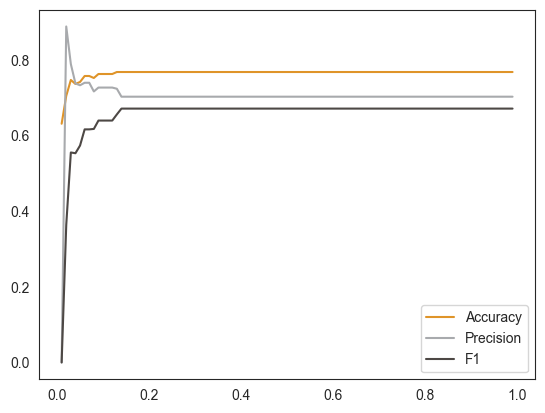

In [78]:
metric_values_df.plot()

C stabilizes at around 0.2 so let's use that as our value

## Final model and scoring

 - For our scoring, since the focus is to predict which recipes will lead to high traffic 80% of the time, the best scoring metric is precision, which only takes into account the percentage of correct prediction of high traffic recipes.
 - Accuracy is also import because we want a model wich can predict both labels (high and low) as accurate as posible.  

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=45)

lr = LogisticRegression(solver="lbfgs", C=0.2)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4) * 100}") 

Accuracy: 76.84


Even though Precision is the best metric for our problem, we can't use the precision_score function from sklearn because it considered the true labels as being 1 and the Label Encoder on the preprocessing phase classified the high_traffic recipes with a zero, so let's do it manually

In [80]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[101,  19],
       [ 25,  45]], dtype=int64)

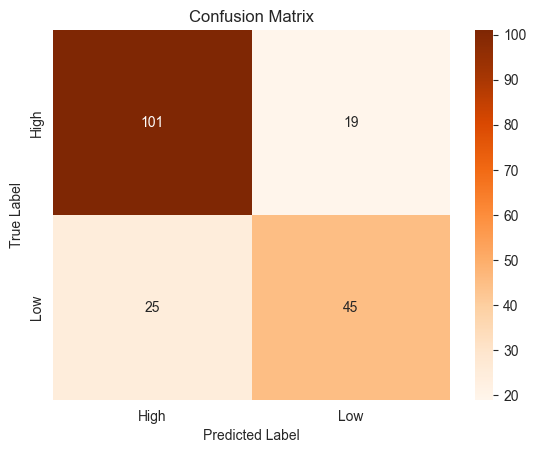

In [84]:
# Plot matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks([0.5, 1.5], labels=["High", "Low"])
plt.xticks([0.5, 1.5], labels=["High", "Low"])
plt.title('Confusion Matrix')
plt.savefig("cm.png", bbox_inches="tight")
plt.show()

In [82]:
#Using the Confunsion Matrix as the reference, the true positives are 101 and the false positives are 19

tp, fp = cm[0]
fn, tn = cm[1]

high_traffic_precision = tp / (tp + fp)

print(f"Precision Score of the high traffic recipes: {round(high_traffic_precision * 100, 2)}%")

Precision Score of the high traffic recipes: 84.17%


In [83]:
#Precision of the truly classified low traffic recipes

low_traffic_precision = tn / (tn + fn)
print(f"Precision Score of the Low traffic recipes: {round(low_traffic_precision * 100, 2)}%")

Precision Score of the Low traffic recipes: 64.29%


## Final summary including recommendations that the business should undertake

Even though the model scored +80% on the high traffic recipes it doesn't seem highly robust for the future since it's highly dependent on one column ("Category").

I recommend Tasty Bytes to start using more data from each recipe, like:
 - Time to make: People may want to choose faster recipes or ones that take longer;
 - Cost per serving: Not knowing the financial condition average of the users, something that's pretty common nowadays and in times of financial tightening is for cheaper recipes to have higher traffic;
 - Ingredients: In my view, this is a very good filter to have on our data, because we can deepen our analysis and separate recipes by specific ingredients, since the category column kind of poor in details.



I hope this report satisfied want the client want it.

Thank you